In [1]:
from __future__ import annotations

import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np

from wufam.data.prepare_data import read_kf_data
from wufam.config.trading_config import TradingConfig
from wufam.dataset import Dataset
from wufam.strategies.base_strategy import BaseStrategy
from wufam.backtest.rolling_backtest import run_rolling_backtest
from wufam.metrics.metrics import calc_sharpe

PATH = Path("../data/kf_data")
START = "1970-01-01"
END = "2024-12-31"
DATASET = Dataset.BM_25_D
FACTORS_DATASET = Dataset.FACTORS_D
WEIGHTING = "value_weighted"
FACTOR_ANNUALIZE = 252

## 1.1

In [3]:
portfolios_total_r, portfolios_xs_r, factors_df, rf = read_kf_data(
    portfolios_filename=PATH / DATASET,
    factors_filename=PATH / FACTORS_DATASET,
    start_date=START,
    end_date=END,
    weighting=WEIGHTING,
)

In [4]:
assert (
    portfolios_total_r.shape[0]
    == portfolios_xs_r.shape[0]
    == factors_df.shape[0]
    == rf.shape[0]
)

## 1.2

In [5]:
from wufam.strategies.heuristics.equally_weighted import EWStrategy
from wufam.strategies.optimized.mean_var import MeanVariance
from wufam.strategies.optimized.min_var import MinVariance

trading_config = TradingConfig(total_exposure=1)

ew_strategy = EWStrategy()

In [6]:
from wufam.estimation.mean.sample_mu_estimator import SampleMuEstimator
from wufam.estimation.covariance.sample_cov_estimator import SampleCovEstimator

mv_strategy = MeanVariance(
    mu_estimator=SampleMuEstimator(),
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [7]:
min_var_strategy = MinVariance(
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [8]:
trading_config_min_var = TradingConfig(total_exposure=1, min_exposure=0.0)

min_var_c_strategy = MinVariance(
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config_min_var,
    window_size=None,
)

In [9]:
trading_config_naive_min_var = TradingConfig(total_exposure=1, min_exposure=0.5 / 25)

min_var_naive_c_strategy = MinVariance(
    cov_estimator=SampleCovEstimator(),
    trading_config=trading_config_naive_min_var,
    window_size=None,
)

In [10]:
from wufam.estimation.covariance.shrinkage.lw_cv_cov_estimator import (
    LedoitWolfCVCovEstimator,
)

min_var_lw_strategy = MinVariance(
    cov_estimator=LedoitWolfCVCovEstimator(),
    trading_config=trading_config,
    window_size=None,
)

In [11]:
min_var_lw_cv_strategy = MinVariance(
    cov_estimator=LedoitWolfCVCovEstimator(alphas=np.linspace(0.0, 1.0, 100)),
    trading_config=trading_config,
    window_size=None,
)

In [12]:
def evaluate_strategy(
    strategy: BaseStrategy, return_weights: bool = False
) -> tuple[float, float] | tuple[float, float, pd.DataFrame]:
    bt_res = run_rolling_backtest(
        strategy=strategy,
        excess_returns=portfolios_xs_r,
        factors=factors_df,
        rf=rf,
        freq="M",
        trading_lag=1,
        return_weights=return_weights,
    )

    if return_weights:
        total_r, turnover, me_weights = bt_res
    else:
        total_r, turnover = bt_res

    sr = calc_sharpe(
        strategy_total_r=total_r,
        rf_rate=rf,
        factor_annualize=FACTOR_ANNUALIZE,
    )

    if return_weights:
        return sr, turnover.mean(), me_weights
    return sr, turnover.mean()

In [13]:
evaluate_strategy(ew_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:00<00:00, 1633.52it/s]


(0.44198649620311253, np.float64(0.01734240132583332))

In [14]:
evaluate_strategy(mv_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:01<00:00, 533.01it/s]


(0.9630608182655956, np.float64(2.3513316852546278))

In [15]:
evaluate_strategy(min_var_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:01<00:00, 593.66it/s]


(0.9572849692685721, np.float64(0.3782886777951084))

In [16]:
from wufam.strategies.timed.vol_managed_strategy import VolManagedStrategy
from wufam.estimation.covariance.factor.factor_cov_estimator import FactorCovEstimator
from wufam.estimation.covariance.shrinkage.pca_cov_estimator import PCACovEstimator
from wufam.estimation.covariance.shrinkage.qis import QISCovEstimator

min_var_qis_strategy = MinVariance(
    cov_estimator=QISCovEstimator(),
    trading_config=trading_config,
    window_size=365,
)

factor_cov_estimator = FactorCovEstimator(
    factor_cov_estimator=SampleCovEstimator(),
    residual_cov_estimator=PCACovEstimator(),
    factors_selection=["Mkt-RF"],
)

min_var_factor_strategy = MinVariance(
    cov_estimator=factor_cov_estimator,
    trading_config=trading_config,
    window_size=365,
)

vol_managed_trading_config = TradingConfig(min_exposure=0.0, max_exposure=2.0)

vol_managed_strategy = VolManagedStrategy(
    trading_config=vol_managed_trading_config,
    vol_window=21,
)

In [17]:
evaluate_strategy(min_var_factor_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:15<00:00, 43.65it/s]


(1.1740884083611147, np.float64(0.9870044492870185))

In [18]:
evaluate_strategy(min_var_qis_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:01<00:00, 345.63it/s]


(1.0747897587797615, np.float64(1.5625791229738906))

In [19]:
evaluate_strategy(vol_managed_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:01<00:00, 644.79it/s] 


(0.5398630805684842, np.float64(0.4403075315505424))

In [20]:
evaluate_strategy(min_var_c_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:08<00:00, 81.32it/s]


(0.6358202198196208, np.float64(0.03522181628663885))

In [21]:
evaluate_strategy(min_var_lw_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:01<00:00, 375.82it/s]


(1.096740805719054, np.float64(0.18765173766302304))

In [22]:
min_var_lw_strategy.cov_estimator.best_alpha

np.float64(0.0012499629205031842)

In [23]:
evaluate_strategy(min_var_lw_cv_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [04:52<00:00,  2.26it/s]


(1.0885113036853014, np.float64(0.19043299837650418))

In [24]:
evaluate_strategy(min_var_naive_c_strategy)

Optimizing Strategy: 100%|██████████| 659/659 [00:05<00:00, 117.94it/s]


(0.5539918349659848, np.float64(0.030069726364223122))

In [25]:
sr, turnover, w = evaluate_strategy(min_var_naive_c_strategy, return_weights=True)
sr, turnover

Optimizing Strategy: 100%|██████████| 659/659 [00:05<00:00, 117.66it/s]


(0.5539918349659848, np.float64(0.030069726364223122))

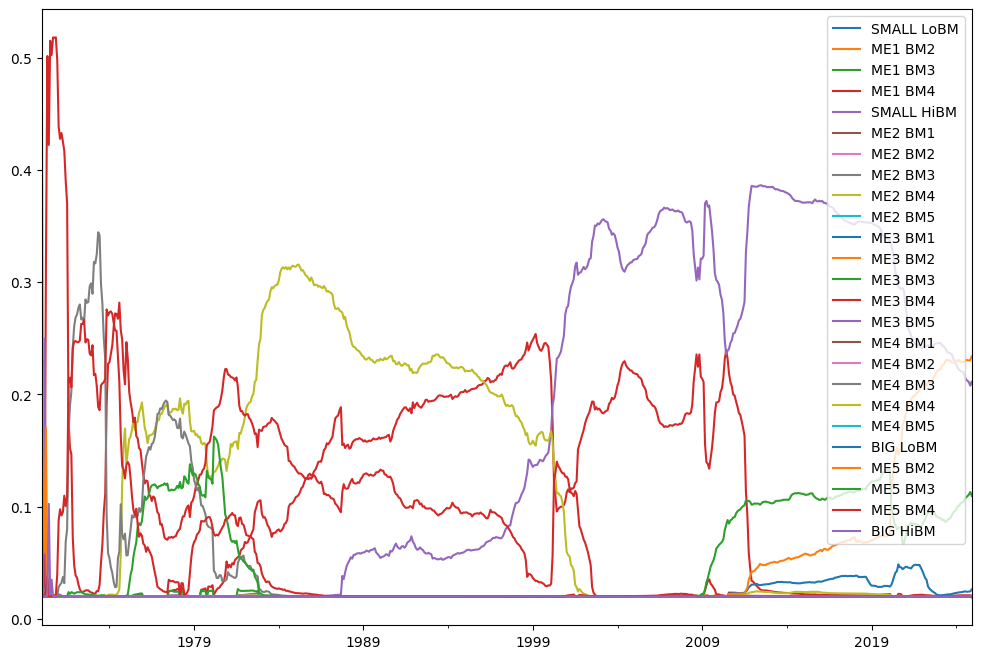

In [26]:
w.resample("ME").last().plot(figsize=(12, 8));